In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import json
import seaborn as sns

In [10]:
#load previous result
folder_name = "results/job_match_0503_2341"

with open(folder_name + '/test_dict.json') as f:
    test_dict = json.load(f)

#get related occupation, filtered by primary-short (most relevant)
related = pd.read_excel('datasets/related_occupations.xlsx').astype(str)
related.columns = related.columns.str.lower().str.replace(" ","_").str.replace("o*net-soc_", "")
related = related[related["relatedness_tier"].isin(["Primary-Short", "Primary-Long"])]


def get_result(code):
    with open(folder_name + '/' + code + '.json') as f:
        career = pd.read_json(f)

    return career

#match suggested career to the related career
def match(code, career):
    #check if direct match
    career = career[career["fit"] == "Best"]
    if len(career[career["code"] == code]) == 1: #direct match
        return 1
    else: #check related match
        related_oc = related[related["code"] == code].drop(labels=["code", "title", "relatedness_tier", "index"], axis=1)
        related_oc.columns = related_oc.columns.str.replace("related_", "")
        merged_df = related_oc.merge(right=career, on="code")
        related_match = len(merged_df) / 10
        return related_match

In [11]:
#load the test samples to df
test = pd.read_json(folder_name + '/sampled_occupation.json')
test

,code,title,description,ind
45,11-9141.00,"Property, Real Estate, and Community Associati...","Plan, direct, or coordinate the selling, buyin...",11
2,11-1021.00,General and Operations Managers,"Plan, direct, or coordinate the operations of ...",11
47,11-9161.00,Emergency Management Directors,Plan and direct disaster response or crisis ma...,11
89,13-1199.05,Sustainability Specialists,"Address organizational sustainability issues, ...",13
79,13-1082.00,Project Management Specialists,"Analyze and coordinate the schedule, timeline,...",13
143,15-2051.01,Business Intelligence Analysts,Produce financial and market intelligence by q...,15
125,15-1255.00,Web and Digital Interface Designers,Design digital user interfaces or websites. De...,15
156,17-2051.00,Civil Engineers,"Perform engineering duties in planning, design...",17
150,17-1022.00,Surveyors,Make exact measurements and determine property...,17
172,17-2141.00,Mechanical Engineers,Perform engineering duties in planning and des...,17


In [12]:
#get jobzone df
jz = pd.read_excel('datasets/job_zone.xlsx')
jz.columns = jz.columns.str.lower().str.replace(" ","_")
jz = jz.drop(labels=['date', 'domain_source'], axis=1)   
jz = jz.rename(columns={'o*net-soc_code':'code', 'job_zone':'zone'})

#merge with test, only keep the zone column, drop the rest
test = test.merge(right=jz, on='code')
test = test.drop(labels=['title_y'], axis=1)
test

#use apply to calculate the match score
test['score'] = test['code'].apply(lambda x: match(x, get_result(x)))
test

,code,title_x,description,ind,zone,score
0,11-9141.00,"Property, Real Estate, and Community Associati...","Plan, direct, or coordinate the selling, buyin...",11,4,0.0
1,11-1021.00,General and Operations Managers,"Plan, direct, or coordinate the operations of ...",11,4,0.2
2,11-9161.00,Emergency Management Directors,Plan and direct disaster response or crisis ma...,11,4,0.1
3,13-1199.05,Sustainability Specialists,"Address organizational sustainability issues, ...",13,4,0.0
4,13-1082.00,Project Management Specialists,"Analyze and coordinate the schedule, timeline,...",13,4,0.0
5,15-2051.01,Business Intelligence Analysts,Produce financial and market intelligence by q...,15,4,1.0
6,15-1255.00,Web and Digital Interface Designers,Design digital user interfaces or websites. De...,15,4,0.0
7,17-2051.00,Civil Engineers,"Perform engineering duties in planning, design...",17,4,0.2
8,17-1022.00,Surveyors,Make exact measurements and determine property...,17,4,0.2
9,17-2141.00,Mechanical Engineers,Perform engineering duties in planning and des...,17,4,1.0


<Figure size 1000x600 with 0 Axes>

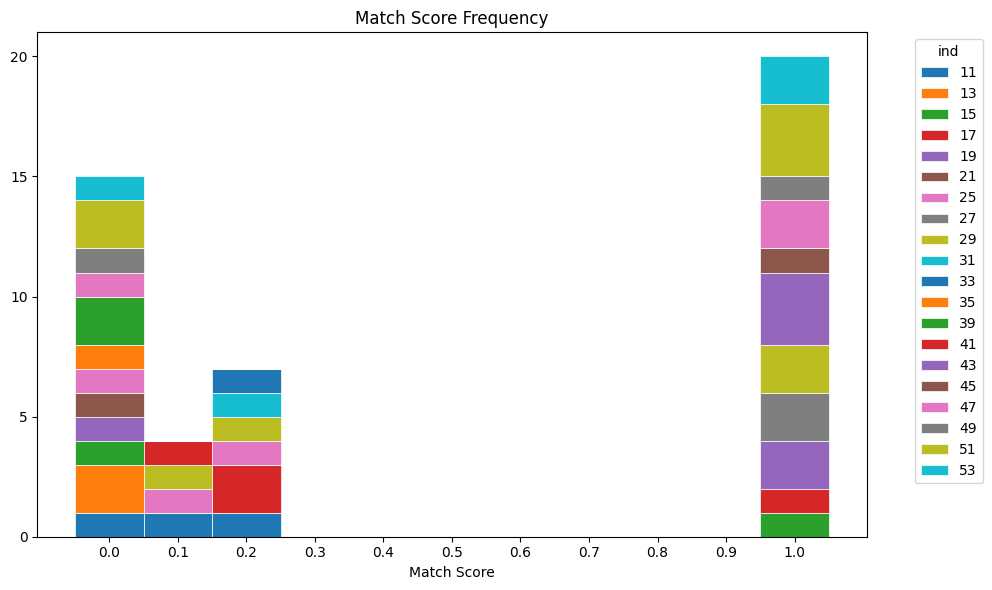

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create figure
plt.figure(figsize=(10, 6))

# Define all possible score values
all_scores = [i/10 for i in list(range(0, 11, 1))]

# Aggregate counts for each score and ind
counts = (test.groupby(['score', 'ind'])
         .size()
         .unstack(fill_value=0)  # Fill missing inds with 0
         .reindex(all_scores, fill_value=0))  # Ensure all scores appear

# Prepare for stacking
pivot_counts = counts.copy()

# Plot stacked bars manually
fig, ax = plt.subplots(figsize=(10, 6))
bottom = np.zeros(len(all_scores))  # Track the bottom of each stack

for ind in pivot_counts.columns:
    ax.bar(
        x=all_scores,
        height=pivot_counts[ind],
        width=0.1,  # Fixed width of 0.1
        bottom=bottom,
        label=ind,
        edgecolor='white',
        linewidth=0.5
    )
    bottom += pivot_counts[ind]  # Update bottom for next stack

# Customize the plot
plt.xticks(all_scores)
plt.yticks(np.arange(0, 21, 5))
plt.title('Match Score Frequency')
plt.xlabel('Match Score')

# Add legend
plt.legend(title='ind', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

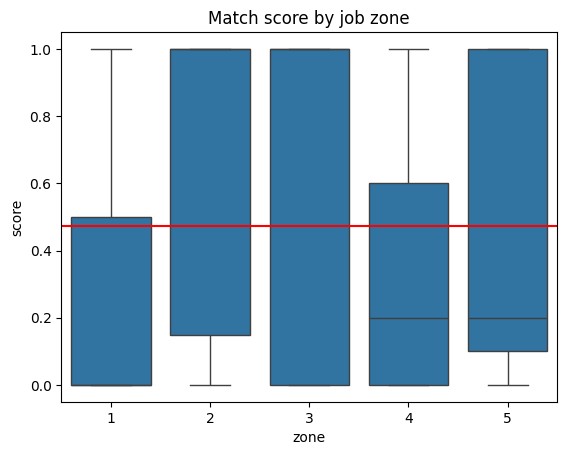

In [31]:
#plot the match score by job zone
sns.boxplot(x='zone', y='score', data=test)
#add a constant line for the average match score
plt.axhline(y= test["score"].sum() / len(test), color='r', linestyle='-')
#add title
plt.title('Match score by job zone')
plt.show()

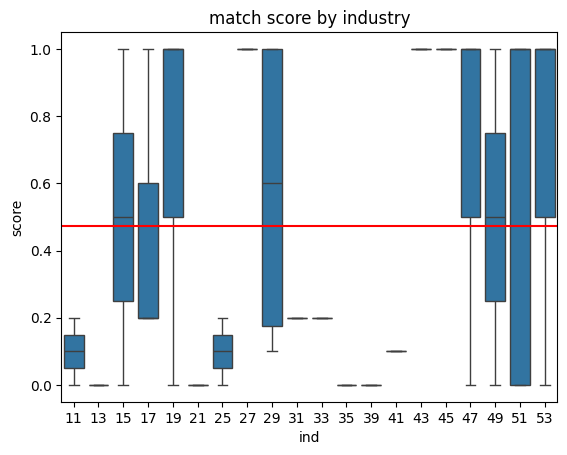

In [32]:
#plot the match score by ind
sns.boxplot(x='ind', y='score', data=test)
plt.axhline(y= test["score"].sum() / len(test), color='r', linestyle='-')
plt.title('match score by industry')
plt.show()